# 03. Classifying MNIST data set using CNN

In [ ]:
# Check for GPU
!nvidia-smi

Thu Jan 11 14:25:19 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# Import torch
import torch

print(torch.__version__)

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

2.1.0+cu121


'cuda'

In [ ]:
import  torchvision
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

## Get data ready and turn it into tensors

In [ ]:
train_data = MNIST(root="data",
                   train=True,
                   download=True,
                   target_transform=None,
                   transform=ToTensor())

test_data = MNIST(root="data",
                  train=False,
                  download=True,
                  target_transform=None,
                  transform = ToTensor())

In [ ]:
img, label = train_data[0]
img.shape, label

(torch.Size([1, 28, 28]), 5)

In [ ]:
len(train_data), len(test_data)

(60000, 10000)

In [ ]:
classes = train_data.classes

In [ ]:
print(len(classes))

10


In [ ]:
random_idx = torch.randint(0, len(train_data),(1,)).item()
random_idx

39045

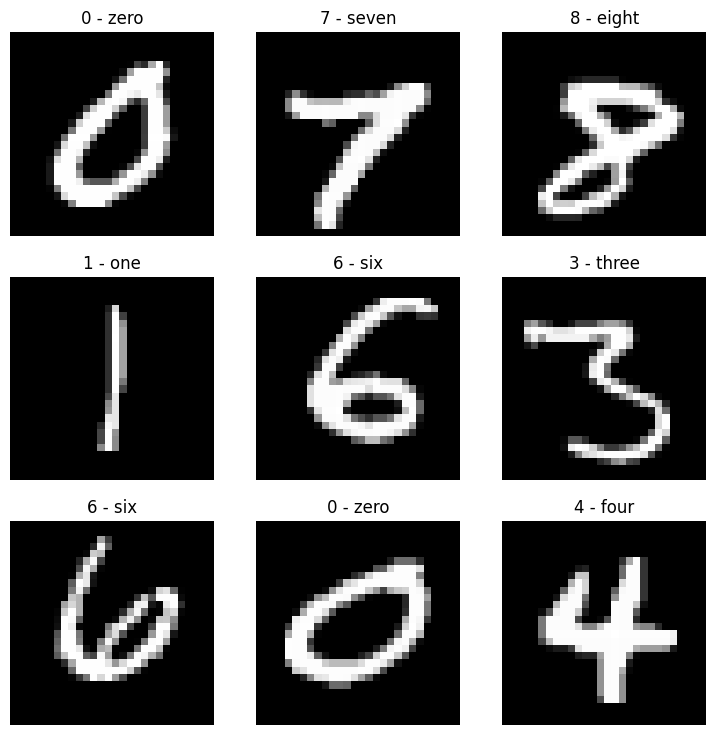

In [ ]:
# lets visualize 9 different sample of the mnist training dataset
import matplotlib.pyplot as plt
number_of_samples = 9
fig = plt.figure(figsize=(9,9))
for i in range(number_of_samples):
  random_idx = torch.randint(0, len(train_data),(1,)).item()
  img, label = train_data[random_idx]
  fig.add_subplot(3,3,i+1)
  plt.imshow(img.squeeze(),cmap="gray")
  plt.title(classes[label])
  plt.axis(False)

In [ ]:
# turn the data to batches to enhance updating of weights and to speed up the training time
from torch.utils.data import DataLoader
batch_size = 32
train_dataloader = DataLoader(train_data,
                              batch_size,
                              shuffle=True
                              )
test_dataloader = DataLoader(test_data,
                             batch_size,
                             shuffle=False)

print(f"there are {len(train_dataloader)} batch of training data || there are {len(test_dataloader)} batch of testing data")

there are 1875 batch of training data || there are 313 batch of testing data


## Model building (I will replicate TinyVGG architecture)

In [ ]:
# replicating tinyVGG architecture
from torch import nn
class MNISTModel_V0(nn.Module):
  def __init__(self,input_shape,hidden_units,output_shape):
    super().__init__()
    self.block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,out_channels = hidden_units,kernel_size=3,padding=1,stride=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,kernel_size=3,padding=1,stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2)
    )
    self.block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2)
    )
    self.FC_layer = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features =hidden_units*7*7 , out_features =output_shape)
    )

  def forward(self,x):
    x = self.block_1(x)
    x = self.block_2(x)
    out_shape_block_2 = x.shape
    x = self.FC_layer(x)
    return x

In [ ]:
# instantiate our model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_0 = MNISTModel_V0(input_shape = 1,hidden_units=10,output_shape = len(classes))

## Model training and evaluation

In [ ]:
# setup a loss function and an optimzer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model_0.parameters(),lr=0.1)

In [ ]:

def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )

        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [ ]:
from timeit import default_timer as timer

def train_time(start,end,device):
  tot_time = end - start
  print(f"total time for training on {device} is {tot_time:.3f}seconds")
  return tot_time

In [ ]:
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               training_time,
               device):
    """Returns a dictionary containing the results of model predicting on data_loader.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X,y = X.to(device), y.to(device)
            # Make predictions with the model
            y_pred = model(X)

            # Accumulate the loss and accuracy values per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y,
                                y_pred=y_pred.argmax(dim=1)) # For accuracy, need the prediction labels (logits -> pred_prob -> pred_labels)

        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)

    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc,
            "training_time": training_time,
            "device": device}

In [ ]:
# Import tqdm for progress bar
from tqdm.auto import tqdm
EPOCHS = 5
start_training_time_model_0 = timer()
for epoch in tqdm(range(EPOCHS)):
  train_step(model=model_0,data_loader=train_dataloader,loss_fn=loss_fn,optimizer=optimizer,accuracy_fn=accuracy_fn,device =device)
  test_step(model=model_0,data_loader = test_dataloader,loss_fn=loss_fn,accuracy_fn=accuracy_fn,device=device)

end_training_time_model_0 = timer()

  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.26959 | Train accuracy: 91.21%
Test loss: 0.07342 | Test accuracy: 97.63%

Train loss: 0.07006 | Train accuracy: 97.83%
Test loss: 0.04498 | Test accuracy: 98.56%

Train loss: 0.05491 | Train accuracy: 98.30%
Test loss: 0.04639 | Test accuracy: 98.37%

Train loss: 0.04565 | Train accuracy: 98.59%
Test loss: 0.04021 | Test accuracy: 98.57%

Train loss: 0.04059 | Train accuracy: 98.68%
Test loss: 0.03543 | Test accuracy: 98.71%



In [ ]:
model_0_train_time = train_time(start=start_training_time_model_0,end=end_training_time_model_0,device=device)
print(model_0_train_time)

total time for training on cuda is 64.576seconds
64.5757079949999


In [ ]:
# eval model 0 results
model_0_results = eval_model(model=model_0,data_loader=test_dataloader,loss_fn=loss_fn,accuracy_fn=accuracy_fn,training_time=model_0_train_time,device=device)
print(model_0_results)

{'model_name': 'MNISTModel_V0', 'model_loss': 0.03542659804224968, 'model_acc': 98.7120607028754, 'training_time': 64.5757079949999, 'device': 'cuda'}


In [ ]:
import pandas as pd
df = pd.DataFrame([model_0_results])
df

,model_name,model_loss,model_acc,training_time,device
0,MNISTModel_V0,0.035427,98.712061,64.575708,cuda


### Make prediction on 9 randomly selected data from test data and plotting out the true vs predicted labels

In [ ]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device

            # Forward pass (model outputs raw logit)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 1, so can perform on dim=0)

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())

    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)


In [ ]:
import random


test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# View the first test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({classes[test_labels[0]]})")

Test sample image shape: torch.Size([1, 28, 28])
Test sample label: 4 (4 - four)


In [ ]:
pred_probs= make_predictions(model=model_0,
                             data=test_samples)

In [ ]:
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([4, 1, 0, 3, 3, 3, 4, 8, 4])

In [ ]:
test_labels, pred_classes

([4, 1, 0, 3, 3, 3, 4, 8, 4], tensor([4, 1, 0, 3, 3, 3, 4, 8, 4]))

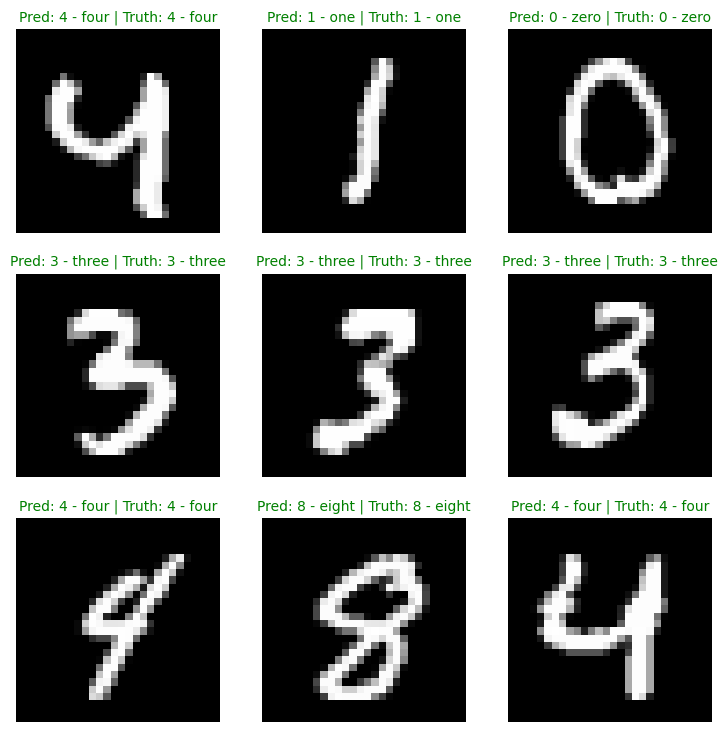

In [ ]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction label (in text form, e.g. "Sandal")
  pred_label = classes[pred_classes[i]]

  # Get the truth label (in text form, e.g. "T-shirt")
  truth_label = classes[test_labels[i]]

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);

### plotting the confusion matrix

In [ ]:
!pip install -q torchmetrics -U mlxtend

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 26.3 MB/s eta 0:00:00


In [ ]:
import torchmetrics, mlxtend
print(torchmetrics.__version__)
print(mlxtend.__version__)

1.3.0
0.23.1


In [ ]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
model_0.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model_0(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/313 [00:00<?, ?it/s]

In [ ]:
y_pred_tensor

tensor([7, 2, 1,  ..., 4, 5, 6])

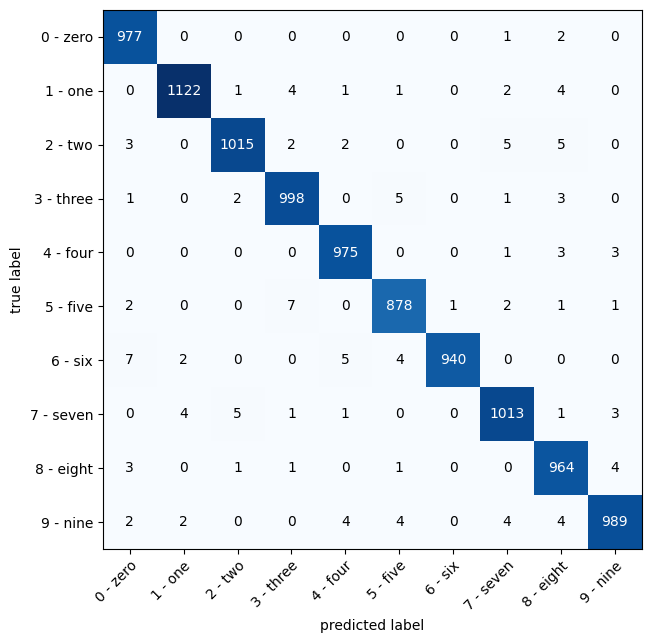

In [ ]:
# plotting the confusion matrix

from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(classes), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy
    class_names=classes, # turn the row and column labels into class names
    figsize=(10, 7)
);